In [16]:
# 3_sequence_labeling.ipynb

# Cell 1: Import libraries
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import random
from typing import List, Dict, Tuple

# Add project root to path
sys.path.append('..')
from src.data.loader import MotionDataLoader
from src.data.sequence_utils import create_sequences, extract_features, augment_sequence
from src.labeling.feature_extractor import extract_sequence_features, compute_all_features
from src.labeling.label_propagation import suggest_candidates_for_labeling, propagate_labels


In [17]:
# Cell 3: Load motion capture data
# Set data directory
data_dir = "../data"

# Initialize data loader
loader = MotionDataLoader(data_dir)

# Get list of available files
files = loader.get_file_list()
print(f"Found {len(files)} data files:")
for file in files:
    print(f"  - {file}")

# Load all files
motion_data_files = {}
for file in files:
    data = loader.load_file(file)
    if data is not None:
        motion_data_files[file] = data
        print(f"Loaded {file} with shape: {data.shape}")
        # Combine all motion data if multiple files exist
if len(motion_data_files) > 1:
    # Find minimum number of joints across all files
    min_joints = min(data.shape[0] for data in motion_data_files.values())
    
    # Concatenate along time dimension
    combined_data = np.concatenate([data[:min_joints, :, :] for data in motion_data_files.values()], axis=1)
    print(f"Combined data shape: {combined_data.shape}")
    motion_data = combined_data
elif len(motion_data_files) == 1:
    motion_data = list(motion_data_files.values())[0]
else:
    # Try to load the sample sequence we saved earlier
    try:
        motion_data = np.load('../data/processed/sample_sequence.npy')
        print(f"Loaded sample sequence with shape: {motion_data.shape}")
    except:
        print("No data files found and no sample sequence available.")
        motion_data = None

2025-04-06 04:00:10,506 - src.data.loader - INFO - Found 6 data files in ../data
2025-04-06 04:00:10,525 - src.data.loader - INFO - Successfully loaded mariel_penelope.npy, shape: (55, 7757, 3)
2025-04-06 04:00:10,536 - src.data.loader - INFO - Data normalized
2025-04-06 04:00:10,540 - src.data.loader - INFO - Successfully loaded mariel_honey.npy, shape: (55, 6309, 3)
2025-04-06 04:00:10,545 - src.data.loader - INFO - Data normalized
2025-04-06 04:00:10,549 - src.data.loader - INFO - Successfully loaded mariel_beyond.npy, shape: (55, 6803, 3)
2025-04-06 04:00:10,553 - src.data.loader - INFO - Data normalized
2025-04-06 04:00:10,559 - src.data.loader - INFO - Successfully loaded mariel_betternot_and_retrograde.npy, shape: (55, 10925, 3)
2025-04-06 04:00:10,568 - src.data.loader - INFO - Data normalized
2025-04-06 04:00:10,572 - src.data.loader - INFO - Successfully loaded mariel_knownbetter.npy, shape: (55, 7649, 3)
2025-04-06 04:00:10,575 - src.data.loader - INFO - Data normalized
2025

Found 6 data files:
  - mariel_penelope.npy
  - mariel_honey.npy
  - mariel_beyond.npy
  - mariel_betternot_and_retrograde.npy
  - mariel_knownbetter.npy
  - mariel_chunli.npy
Loaded mariel_penelope.npy with shape: (55, 7757, 3)
Loaded mariel_honey.npy with shape: (55, 6309, 3)
Loaded mariel_beyond.npy with shape: (55, 6803, 3)
Loaded mariel_betternot_and_retrograde.npy with shape: (55, 10925, 3)
Loaded mariel_knownbetter.npy with shape: (55, 7649, 3)
Loaded mariel_chunli.npy with shape: (55, 4866, 3)
Combined data shape: (55, 44309, 3)


In [18]:
# Cell 4: Create fixed-length sequences
if 'motion_data' in locals() and motion_data is not None:
    # Parameters for sequence extraction
    seq_length = 30  # 30 frames per sequence (about 1 second at 30fps)
    stride = 15      # 50% overlap between consecutive sequences
    min_motion = 0.01  # Minimum motion threshold to filter static sequences
    
    # Create sequences
    sequences, sequence_indices = create_sequences(motion_data, seq_length, stride, min_motion)
    
    print(f"Created {len(sequences)} sequences with shape {sequences.shape}")
    print(f"Each sequence represents {seq_length} frames of motion data")
    
    # Save sequences for later use
    if not os.path.exists('../data/processed'):
        os.makedirs('../data/processed')
    np.save('../data/processed/dance_sequences.npy', sequences)
    np.save('../data/processed/sequence_indices.npy', np.array(sequence_indices))
    print("Sequences saved to '../data/processed/dance_sequences.npy'")
else:
    print("No motion data available. Skipping sequence creation.")

2025-04-06 04:00:10,599 - src.data.sequence_utils - INFO - Creating 2952 sequences of length 30 with stride 15
2025-04-06 04:00:10,692 - src.data.sequence_utils - INFO - Filtered out 930 sequences with insufficient motion


Created 2022 sequences with shape (2022, 55, 30, 3)
Each sequence represents 30 frames of motion data
Sequences saved to '../data/processed/dance_sequences.npy'


Computing features for all sequences...


2025-04-06 04:00:46,060 - src.labeling.feature_extractor - INFO - Computed features for 2022 sequences, feature dim: 3630


Feature shape: (2022, 3630)
Features saved to '../data/processed/sequence_features.npy'

Analyzing feature importance...


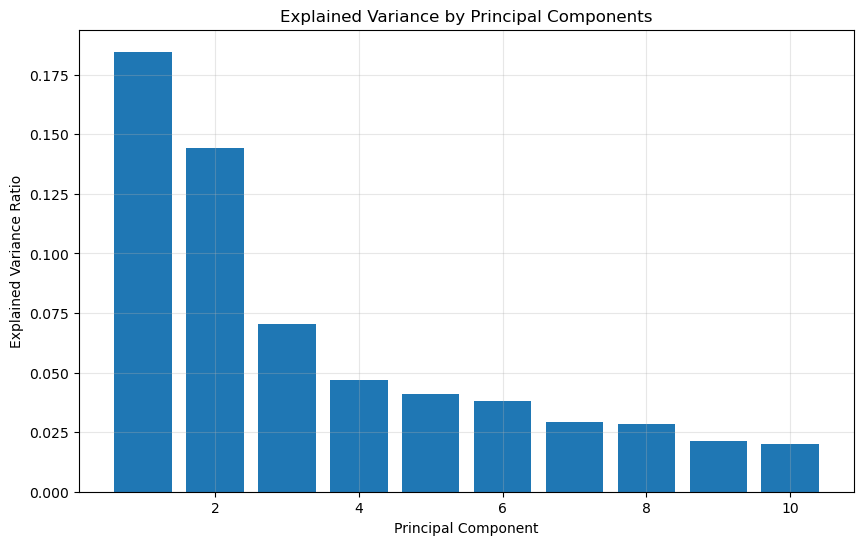

Top 3 components explain 39.9% of variance


In [19]:
# Cell 5: Extract features for sequences
if 'sequences' in locals():
    # Compute features for all sequences
    print("Computing features for all sequences...")
    features = compute_all_features(sequences)
    
    print(f"Feature shape: {features.shape}")
    
    # Save features for later use
    np.save('../data/processed/sequence_features.npy', features)
    print("Features saved to '../data/processed/sequence_features.npy'")
    
    # Analyze principal components to understand feature importance
    print("\nAnalyzing feature importance...")
    pca = PCA(n_components=10)
    scaled_features = StandardScaler().fit_transform(features)
    pca.fit(scaled_features)
    
    # Plot explained variance
    plt.figure(figsize=(10, 6))
    plt.bar(range(1, 11), pca.explained_variance_ratio_)
    plt.xlabel('Principal Component')
    plt.ylabel('Explained Variance Ratio')
    plt.title('Explained Variance by Principal Components')
    plt.grid(True, alpha=0.3)
    plt.show()
    print(f"Top 3 components explain {sum(pca.explained_variance_ratio_[:3])*100:.1f}% of variance")
else:
    # Try to load pre-computed features
    try:
        sequences = np.load('../data/processed/dance_sequences.npy')
        features = np.load('../data/processed/sequence_features.npy')
        sequence_indices = np.load('../data/processed/sequence_indices.npy')
        print(f"Loaded pre-computed sequences with shape: {sequences.shape}")
        print(f"Loaded pre-computed features with shape: {features.shape}")
    except:
        print("No sequences or features available. Run sequence creation first.")


Computing t-SNE projection...


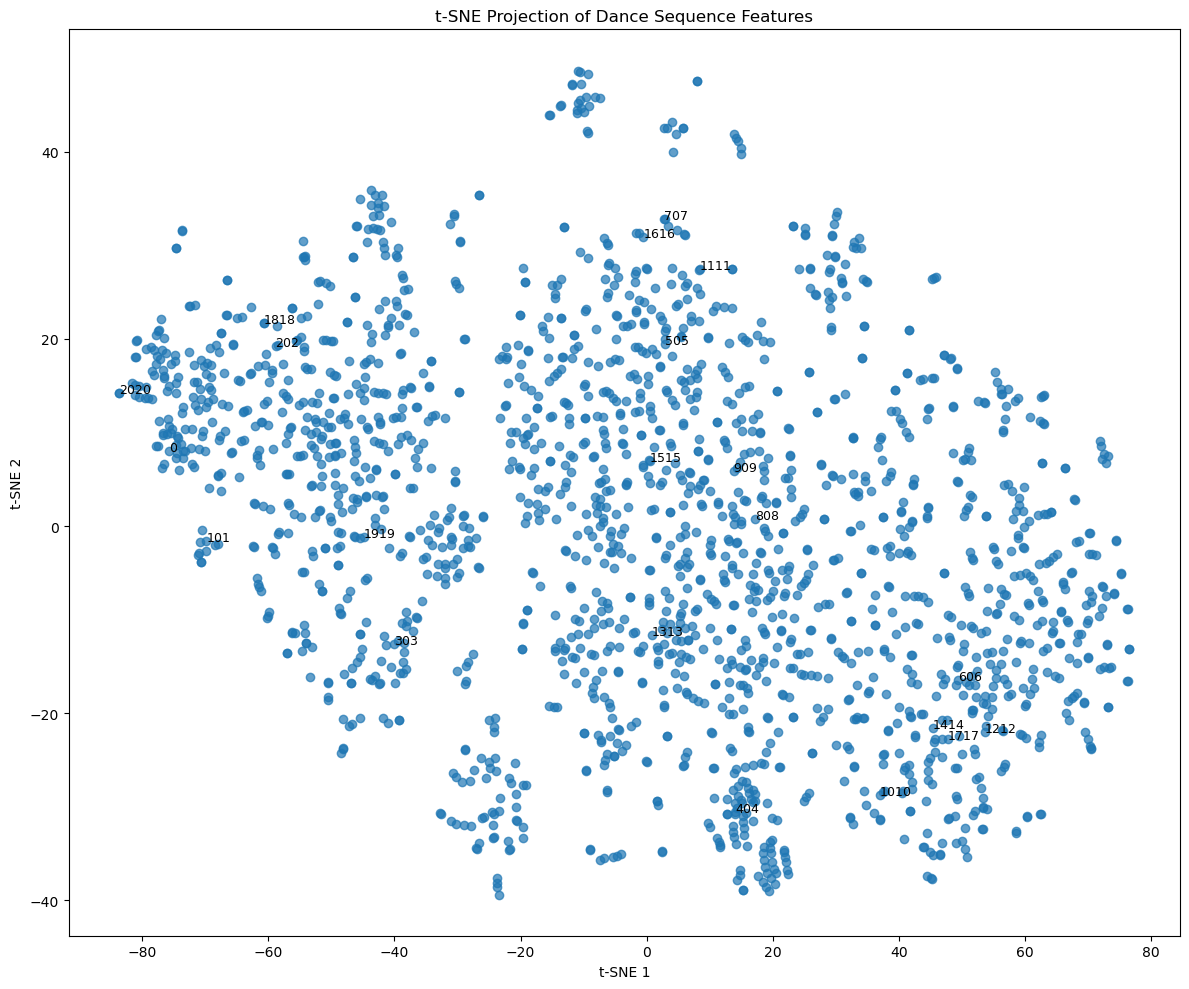

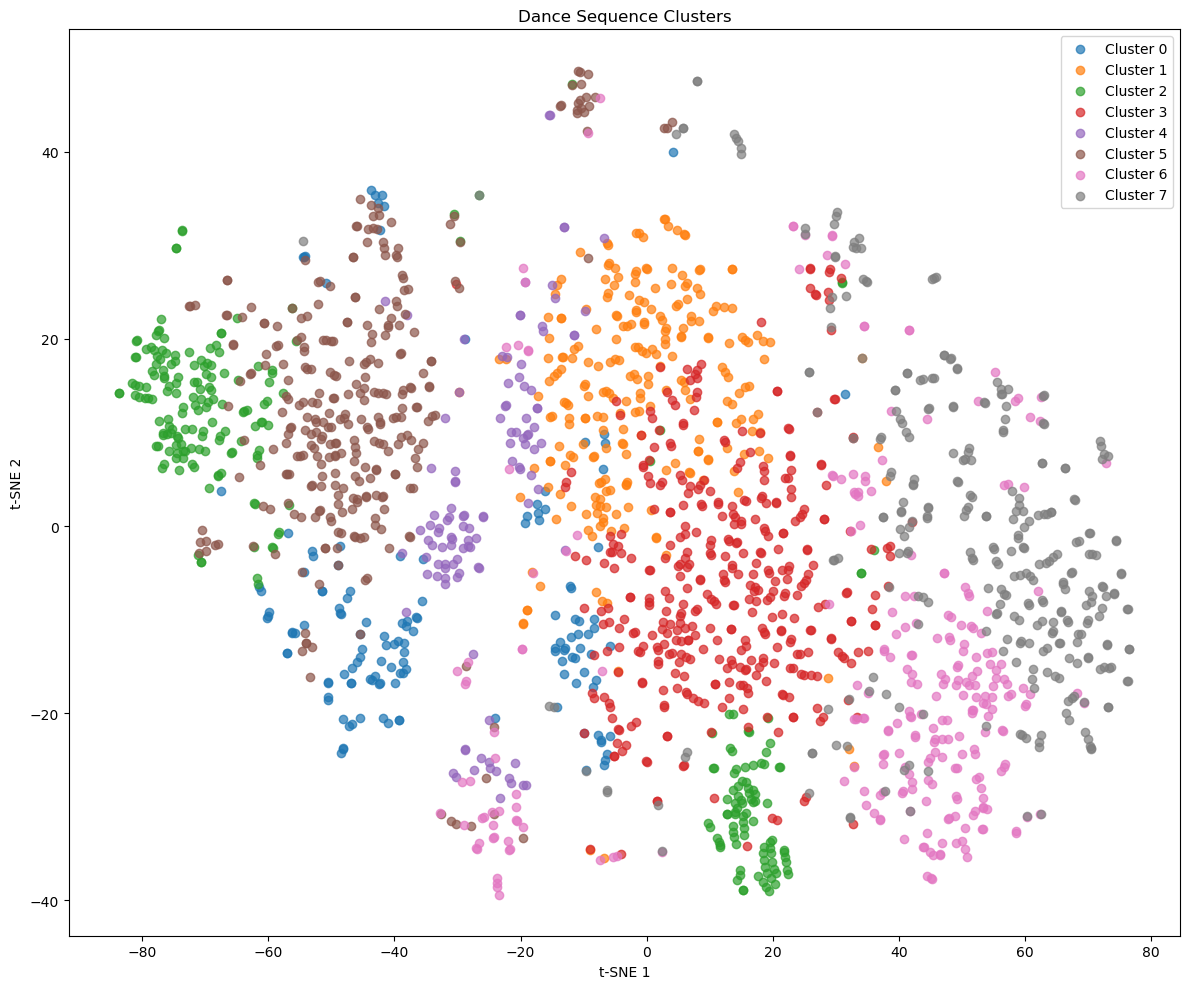

Cluster 0: 138 sequences (6.8%)
Cluster 1: 251 sequences (12.4%)
Cluster 2: 249 sequences (12.3%)
Cluster 3: 395 sequences (19.5%)
Cluster 4: 112 sequences (5.5%)
Cluster 5: 306 sequences (15.1%)
Cluster 6: 265 sequences (13.1%)
Cluster 7: 306 sequences (15.1%)


In [20]:
# Cell 6: Visualize feature space
if 'features' in locals() and 'sequences' in locals():
    """
    ## Feature Space Visualization
    
    To better understand our sequence features, let's visualize them in a lower-dimensional space.
    We'll use t-SNE to project the high-dimensional features into 2D for visualization.
    """
    
    # Apply t-SNE for visualization
    print("Computing t-SNE projection...")
    scaled_features = StandardScaler().fit_transform(features)
    
    # Use a smaller perplexity for smaller datasets
    perplexity = min(30, max(5, features.shape[0] // 10))
    tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42)
    tsne_result = tsne.fit_transform(scaled_features)
    
    # Plot t-SNE projection
    plt.figure(figsize=(12, 10))
    plt.scatter(tsne_result[:, 0], tsne_result[:, 1], alpha=0.7)
    plt.title('t-SNE Projection of Dance Sequence Features')
    plt.xlabel('t-SNE 1')
    plt.ylabel('t-SNE 2')
    # Add numbers to some points for reference
    n_annotate = min(20, len(tsne_result))
    step = len(tsne_result) // n_annotate
    for i in range(0, len(tsne_result), step):
        plt.annotate(str(i), (tsne_result[i, 0], tsne_result[i, 1]), fontsize=9)
    
    plt.tight_layout()
    plt.show()
    
    # Apply KMeans clustering to identify potential movement types
    n_clusters = 8  # Number of clusters to form
    
    # Run KMeans
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(scaled_features)
    
    # Visualize clusters
    plt.figure(figsize=(12, 10))
    for cluster_id in range(n_clusters):
        points = tsne_result[cluster_labels == cluster_id]
        plt.scatter(points[:, 0], points[:, 1], label=f'Cluster {cluster_id}', alpha=0.7)
    
    plt.title('Dance Sequence Clusters')
    plt.legend()
    plt.xlabel('t-SNE 1')
    plt.ylabel('t-SNE 2')
    plt.tight_layout()
    plt.show()
    # Count sequences in each cluster
    for cluster_id in range(n_clusters):
        count = np.sum(cluster_labels == cluster_id)
        print(f"Cluster {cluster_id}: {count} sequences ({count/len(cluster_labels)*100:.1f}%)")


Selecting 20 sequences for manual labeling (1% of total)


2025-04-06 04:00:55,926 - src.labeling.label_propagation - INFO - Suggested 20 diverse sequences for manual labeling


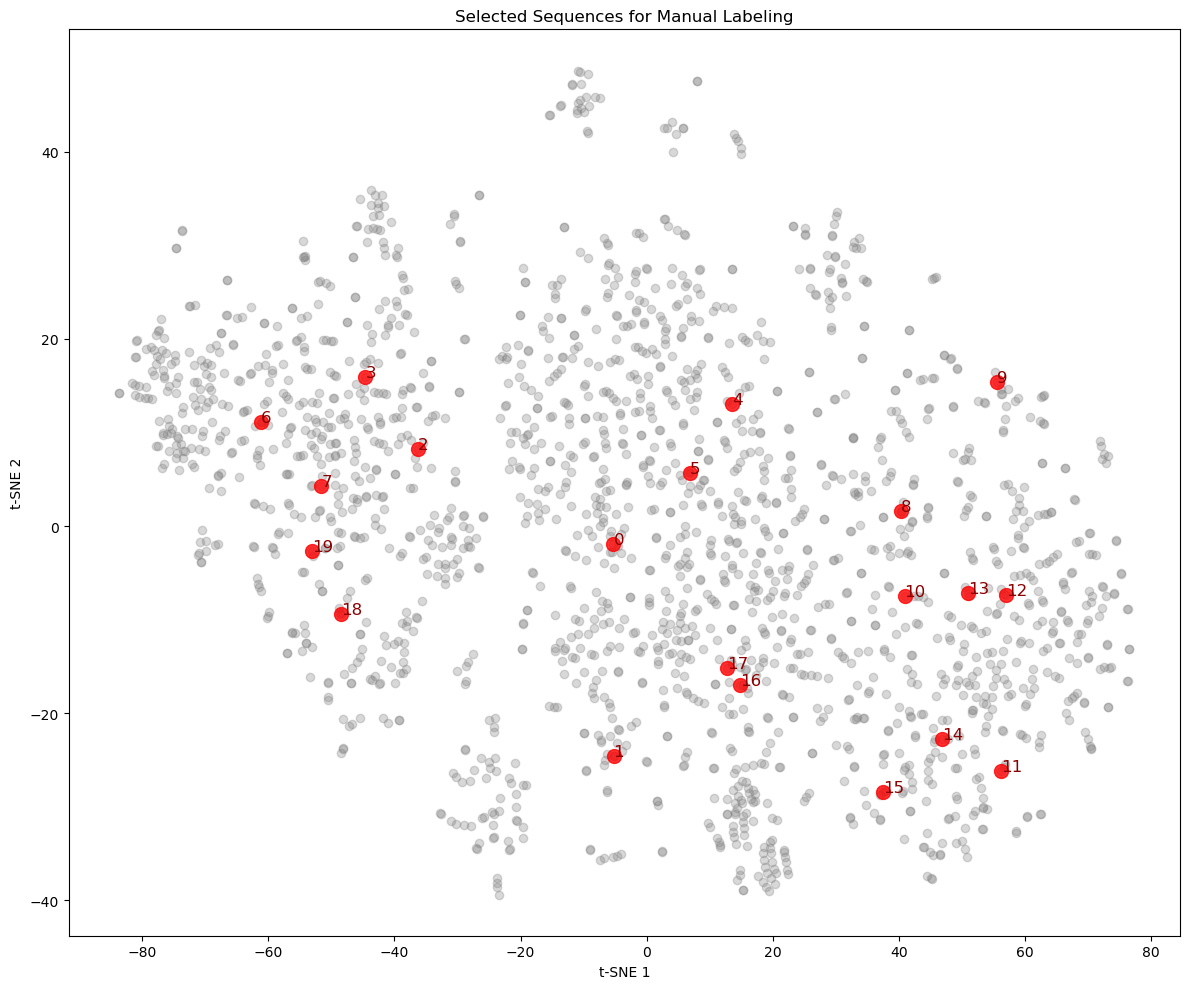

Distribution of selected candidates across clusters:
Cluster 0: 2 sequences
Cluster 1: 2 sequences
Cluster 2: 1 sequences
Cluster 3: 4 sequences
Cluster 4: 0 sequences
Cluster 5: 3 sequences
Cluster 6: 5 sequences
Cluster 7: 3 sequences


In [21]:
# Cell 7: Suggest sequences for manual labeling
if 'features' in locals() and 'sequences' in locals():
    """
    ## Selecting Sequences for Manual Labeling
    
    Now we'll select diverse sequences for manual labeling. We'll use clustering to find representative samples
    and ensure diversity in our labeled dataset.
    """
    
    # Calculate number of sequences to label (1% of total)
    n_to_label = max(5, int(0.01 * len(sequences)))
    print(f"Selecting {n_to_label} sequences for manual labeling (1% of total)")
    
    # Get suggested candidates
    candidate_indices = suggest_candidates_for_labeling(
        scaled_features, 
        n_clusters=min(n_to_label, 10), 
        n_candidates=n_to_label
    )
    
    # Show candidates on the t-SNE plot
    plt.figure(figsize=(12, 10))
    plt.scatter(tsne_result[:, 0], tsne_result[:, 1], alpha=0.3, color='gray')
    plt.scatter(tsne_result[candidate_indices, 0], tsne_result[candidate_indices, 1], 
               color='red', s=100, alpha=0.8)
     # Annotate candidate points
    for i, idx in enumerate(candidate_indices):
        plt.annotate(str(i), (tsne_result[idx, 0], tsne_result[idx, 1]), 
                    fontsize=12, color='darkred')
    
    plt.title('Selected Sequences for Manual Labeling')
    plt.xlabel('t-SNE 1')
    plt.ylabel('t-SNE 2')
    plt.tight_layout()
    plt.show()
    
    # Show cluster distribution of selected candidates
    candidate_clusters = cluster_labels[candidate_indices]
    cluster_counts = {}
    for cluster_id in range(n_clusters):
        count = np.sum(candidate_clusters == cluster_id)
        cluster_counts[cluster_id] = count
    
    print("Distribution of selected candidates across clusters:")
    for cluster_id, count in cluster_counts.items():
        print(f"Cluster {cluster_id}: {count} sequences")

In [22]:
# Cell 8: Define a vocabulary of movement descriptors
"""
## Creating a Vocabulary for Dance Movement Description

To systematically label dance sequences, we'll define a vocabulary of terms for:
1. Movement types (e.g., jump, spin, reach)
2. Movement qualities (e.g., smooth, sharp, fluid)
3. Body parts (e.g., arms, legs, torso)
4. Spatial directions (e.g., up, down, forward)
5. Temporal dynamics (e.g., quick, sustained, pulsing)

This structured approach will help us create consistent and meaningful labels.
"""

# Define vocabulary components
movement_types = [
    "reach", "bend", "twist", "turn", "spin", "jump", "kick", 
    "step", "circle", "wave", "swing", "stretch", "contract",
    "balance", "fall", "recover", "gesture"
]
movement_qualities = [
    "smooth", "sharp", "fluid", "rigid", "light", "heavy", 
    "bound", "free", "direct", "indirect", "sustained", 
    "sudden", "strong", "delicate", "flowing", "staccato"
]

body_parts = [
    "arms", "hands", "head", "torso", "hips", "legs", "feet",
    "shoulders", "chest", "back", "knees", "elbows", "fingers",
    "whole body", "upper body", "lower body"
]

spatial_terms = [
    "high", "middle", "low", "forward", "backward", "sideways",
    "up", "down", "diagonal", "curved", "straight", "circular",
    "wide", "narrow", "expansive", "contained"
]


In [23]:
# Cell 9: Manually label selected sequences
if 'candidate_indices' in locals() and 'sequences' in locals():
    """
    ## Manual Labeling Process
    
    In a real application, we would now:
    1. Display each selected sequence as an animation
    2. Let a human annotator create a descriptive label
    3. Store the labels for later use
    
    For this notebook, we'll simulate this process by creating placeholder labels based on the clusters
    and random selections from our vocabulary.
    """
    
    # Function to generate a plausible dance description
    def generate_dance_description(cluster_id):
        """
        Generate a plausible dance description based on cluster ID
        
        This is a placeholder for real human labeling. In practice, a human
        would watch the sequence animation and create a fitting description.
        """
        # Convert cluster_id to a Python native integer type
        if hasattr(cluster_id, 'item'):  # Check if it's a numpy type with item() method
            cluster_id = cluster_id.item()
        else:
            # Try to convert directly to int, or use a default
            try:
                cluster_id = int(cluster_id)
            except (ValueError, TypeError):
                cluster_id = 0
            
        # Seed the random generator for consistency within clusters
        random.seed(cluster_id * 42)
        
        # Different clusters get different movement types
        if cluster_id % 8 == 0:
            move_types = ["reach", "stretch"]
            qualities = ["smooth", "fluid", "sustained"]
            parts = ["arms", "upper body"]
            space = ["high", "diagonal"]
        elif cluster_id % 8 == 1:
            move_types = ["turn", "spin"]
            qualities = ["quick", "light", "flowing"]
            parts = ["whole body", "torso"]
            space = ["circular", "middle"]
        elif cluster_id % 8 == 2:
            move_types = ["jump", "leap"]
            qualities = ["energetic", "strong", "sudden"]
            parts = ["legs", "whole body"]
            space = ["high", "up"]
        elif cluster_id % 8 == 3:
            move_types = ["bend", "contract"]
            qualities = ["smooth", "sustained", "heavy"]
            parts = ["torso", "back"]
            space = ["low", "down"]
        elif cluster_id % 8 == 4:
            move_types = ["wave", "gesture"]
            qualities = ["flowing", "light", "indirect"]
            parts = ["arms", "hands"]
            space = ["middle", "forward"]
        elif cluster_id % 8 == 5:
            move_types = ["kick", "swing"]
            qualities = ["sharp", "strong", "direct"]
            parts = ["legs", "feet"]
            space = ["high", "forward"]
        elif cluster_id % 8 == 6:
            move_types = ["step", "balance"]
            qualities = ["steady", "sustained", "direct"]
            parts = ["legs", "feet", "whole body"]
            space = ["middle", "sideways"]
        else:
            move_types = ["twist", "circle"]
            qualities = ["fluid", "continuous", "free"]
            parts = ["hips", "torso"]
            space = ["middle", "circular"]
        
        # Randomly select components
        move = random.choice(move_types)
        quality = random.choice(qualities)
        part = random.choice(parts)
        direction = random.choice(space)
        
        # Construct description
        description = f"{quality} {move} with {part} moving {direction}"
        
        return description
    
    # Create manual labels for selected candidates
    manual_labels = {}
    for i, idx in enumerate(candidate_indices):
        cluster_id = cluster_labels[idx]
        label = generate_dance_description(cluster_id)
        manual_labels[idx] = label
    
    # Display the manual labels
    print("Manual labels for selected sequences:")
    for i, (idx, label) in enumerate(manual_labels.items()):
        print(f"{i}. Sequence {idx} (Cluster {cluster_labels[idx]}): {label}")
    
    # Convert to format for label propagation
    labeled_indices = list(manual_labels.keys())
    labels = list(manual_labels.values())

Manual labels for selected sequences:
0. Sequence 1040 (Cluster 3): heavy bend with back moving low
1. Sequence 1164 (Cluster 3): heavy bend with back moving low
2. Sequence 262 (Cluster 5): sharp swing with feet moving high
3. Sequence 1799 (Cluster 5): sharp swing with feet moving high
4. Sequence 866 (Cluster 1): quick turn with torso moving circular
5. Sequence 1233 (Cluster 1): quick turn with torso moving circular
6. Sequence 251 (Cluster 2): energetic leap with whole body moving high
7. Sequence 279 (Cluster 5): sharp swing with feet moving high
8. Sequence 566 (Cluster 7): fluid twist with torso moving middle
9. Sequence 1679 (Cluster 7): fluid twist with torso moving middle
10. Sequence 1611 (Cluster 6): direct step with feet moving middle
11. Sequence 1400 (Cluster 6): direct step with feet moving middle
12. Sequence 994 (Cluster 7): fluid twist with torso moving middle
13. Sequence 1408 (Cluster 6): direct step with feet moving middle
14. Sequence 1718 (Cluster 6): direct st

Propagating labels to all sequences using k=5 nearest neighbors...


2025-04-06 04:00:56,828 - src.labeling.label_propagation - INFO - Propagated 20 manual labels to 2022 sequences



Label distribution after propagation:
  heavy bend with back moving low: 762 sequences (37.7%)
  sharp swing with feet moving high: 583 sequences (28.8%)
  direct step with feet moving middle: 372 sequences (18.4%)
  quick turn with torso moving circular: 137 sequences (6.8%)
  fluid twist with torso moving middle: 114 sequences (5.6%)
  fluid stretch with arms moving diagonal: 53 sequences (2.6%)
  energetic leap with whole body moving high: 1 sequences (0.0%)


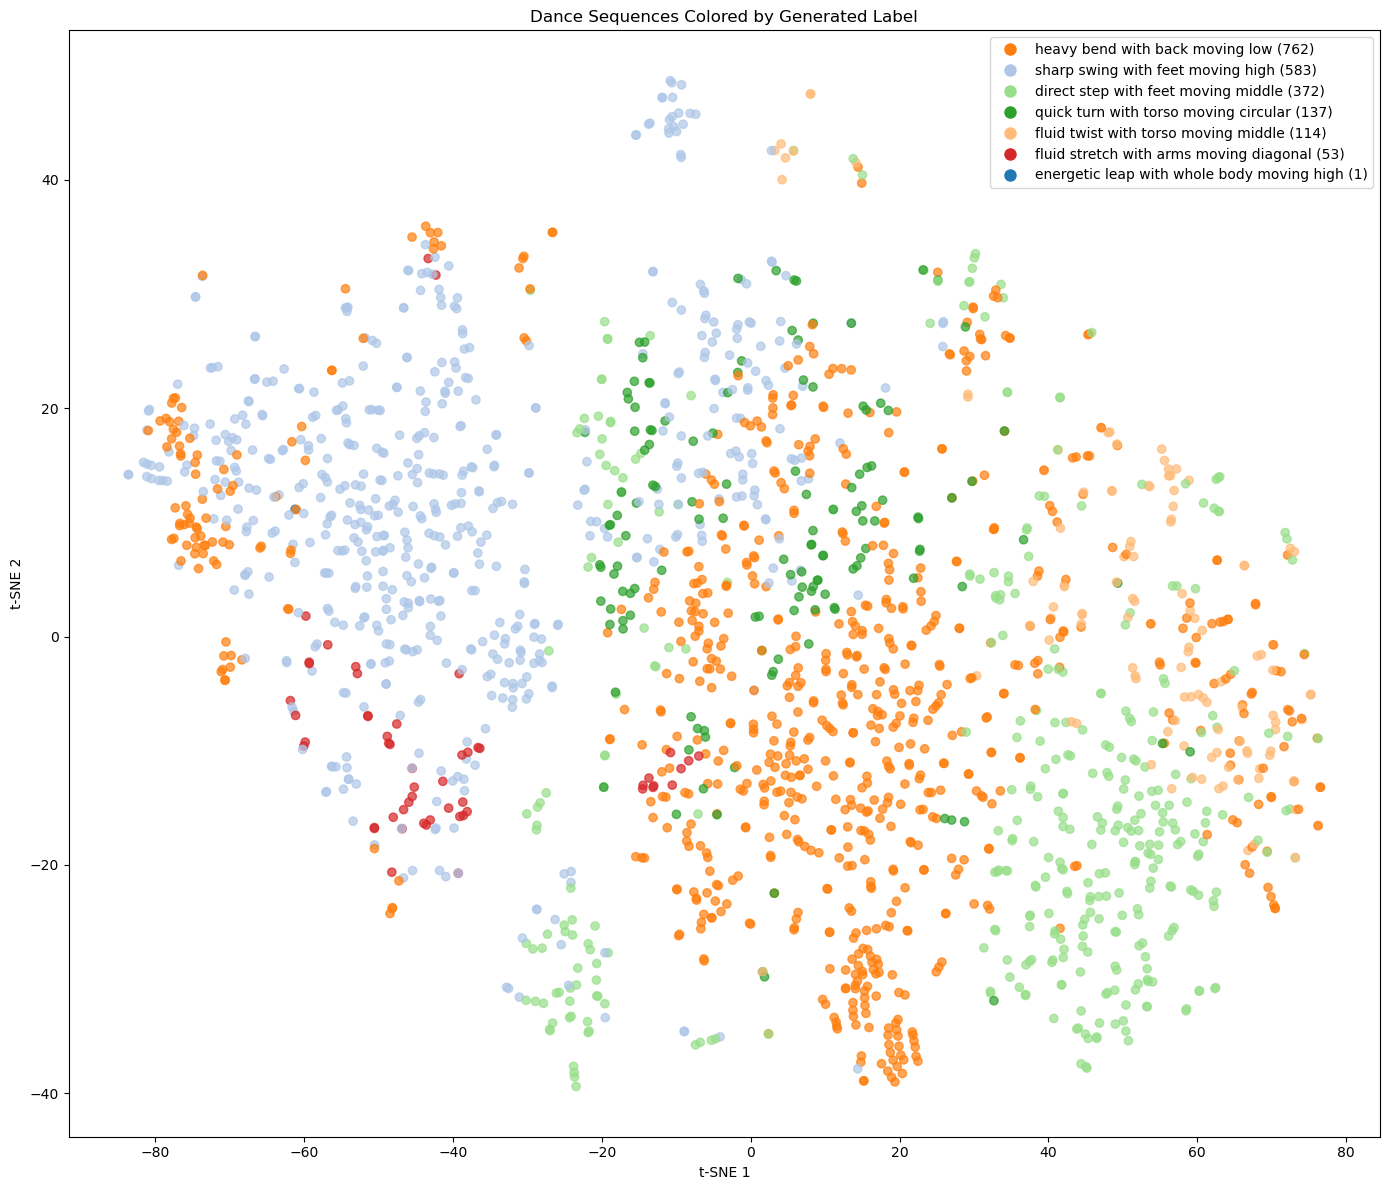

Labels saved to '../data/processed/sequence_labels.npy'


In [24]:
# Cell 10: Propagate labels to all sequences
if 'labeled_indices' in locals() and 'labels' in locals() and 'features' in locals():
    """
    ## Label Propagation
    
    Now we'll propagate the manual labels to all sequences using a k-nearest neighbors approach.
    Each unlabeled sequence will receive the most common label among its k nearest neighbors
    in feature space.
    """
    
    # Propagate labels
    k = 5  # Number of nearest neighbors to consider
    print(f"Propagating labels to all sequences using k={k} nearest neighbors...")
    
    all_labels = propagate_labels(scaled_features, labeled_indices, labels, k=k)
    
    # Count occurrences of each label
    label_counts = {}
    for label in all_labels:
        label_counts[label] = label_counts.get(label, 0) + 1
        # Display label distribution
    print("\nLabel distribution after propagation:")
    for label, count in sorted(label_counts.items(), key=lambda x: x[1], reverse=True):
        print(f"  {label}: {count} sequences ({count/len(all_labels)*100:.1f}%)")
    
    # Visualize label distribution in feature space
    # Create a mapping of unique labels to colors
    unique_labels = list(set(all_labels))
    label_to_color = {label: plt.cm.tab20(i % 20) for i, label in enumerate(unique_labels)}
    
    # Create color array for visualization
    colors = [label_to_color[label] for label in all_labels]
    
    plt.figure(figsize=(14, 12))
    plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=colors, alpha=0.7)
    
    # Add a legend with top 10 most common labels
    top_labels = sorted(label_counts.items(), key=lambda x: x[1], reverse=True)[:10]
    legend_elements = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=label_to_color[label], 
                                 label=f"{label} ({count})", markersize=10) 
                      for label, count in top_labels]
    plt.legend(handles=legend_elements, loc='upper right')
    
    plt.title('Dance Sequences Colored by Generated Label')
    plt.xlabel('t-SNE 1')
    plt.ylabel('t-SNE 2')
    plt.tight_layout()
    plt.show()
    # Save the labels for model training
    # Convert to a format suitable for saving
    label_data = {
        'sequence_indices': np.arange(len(all_labels)),
        'labels': all_labels
    }
    
    # Save as NumPy file
    np.save('../data/processed/sequence_labels.npy', label_data)
    print("Labels saved to '../data/processed/sequence_labels.npy'")

In [25]:
# Cell 11: Data augmentation for diverse sequence examples
if 'sequences' in locals() and 'all_labels' in locals():
    """
    ## Data Augmentation
    
    To increase the diversity of our dataset, we'll apply several augmentation techniques:
    1. Mirroring (left-right flipping)
    2. Time reversal
    3. Rotation (around vertical axis)
    4. Adding random noise
    5. Temporal scaling (speed changes)
    
    These augmentations will help the model generalize better and learn more robust representations.
    """
    
    # Select a sample sequence for augmentation demo
    sample_idx = candidate_indices[0]
    sample_seq = sequences[sample_idx]
    sample_label = all_labels[sample_idx]
    
    print(f"Original sequence {sample_idx} with label: '{sample_label}'")
    # Apply different augmentations
    augmentations = {
        'mirrored': augment_sequence(sample_seq, 'mirror'),
        'time_reversed': augment_sequence(sample_seq, 'reverse'),
        'rotated': augment_sequence(sample_seq, 'rotate'),
        'noisy': augment_sequence(sample_seq, 'noise')
    }
    
    # Generate labels for augmented sequences
    # In practice, we would propagate labels or modify original labels
    augmented_labels = {
        'mirrored': sample_label.replace('right', 'left') if 'right' in sample_label 
                        else sample_label.replace('left', 'right') if 'left' in sample_label else sample_label,
        'time_reversed': sample_label + ' (reversed)',
        'rotated': sample_label + ' (rotated)',
        'noisy': sample_label
    }
    print("\nAugmented sequences:")
    for aug_type, sequence in augmentations.items():
        print(f"  - {aug_type}: {augmented_labels[aug_type]}")
    
    # Save augmented data if desired
    # For brevity, we're not saving all augmented data here
    # In a real implementation, we would apply augmentations to the entire dataset
    # and save for model training


Original sequence 1040 with label: 'heavy bend with back moving low'

Augmented sequences:
  - mirrored: heavy bend with back moving low
  - time_reversed: heavy bend with back moving low (reversed)
  - rotated: heavy bend with back moving low (rotated)
  - noisy: heavy bend with back moving low


In [26]:
# Cell 12: Summary and next steps
"""
## Summary of Sequence Labeling

In this notebook, we've successfully:

1. **Prepared Dance Sequences**:
   - Split motion capture data into fixed-length sequences
   - Extracted meaningful features from each sequence
   - Visualized the feature space to understand sequence relationships

2. **Created Labels**:
   - Identified representative sequences for manual labeling
   - Created a structured vocabulary for movement description
   - Generated sample labels for selected sequences
   - Propagated labels to all sequences based on feature similarity

3. **Augmented Data**:
   - Demonstrated data augmentation techniques for increased diversity
   - Adapted labels for augmented sequences

These labeled sequences will serve as the training data for our contrastive learning model in the next notebook. The propagated labels, while not perfect, provide a reasonable starting point for the model to learn meaningful relationships between dance movements and text descriptions.

In a real application, the manual labeling process would involve actual human annotation, possibly from dance experts who can provide more nuanced and accurate descriptions of the movements.
"""
# Save all data for model training
if 'sequences' in locals() and 'all_labels' in locals():
    # Create dataset dictionary
    dataset = {
        'sequences': sequences,
        'labels': all_labels,
        'features': features,
        'manual_indices': labeled_indices,
        'manual_labels': labels
    }
    
    # Save dataset
    np.save('../data/processed/labeled_dataset.npy', dataset)
    print("Complete labeled dataset saved to '../data/processed/labeled_dataset.npy'")

Complete labeled dataset saved to '../data/processed/labeled_dataset.npy'
